In [1]:


from matplotlib.ticker import PercentFormatter

from common import *
from record_preprocess import *

In [2]:

load_all_play_records()

/Users/purchaser/PycharmProjects/MMKP-solver/src/data_source.py:58: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.most_memory_consumption: int = stats.mode(memories)[0][0]


Data sources loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/src/plots/datas/reports/Player_trace_cluster_64_data_source_phi_static_MMKP_no_spread_2023-03-14-15-21-31/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/src/plots/datas/reports/Player_trace_cluster_64_data_source_ali_static_Tiresias_2023-03-14-16-32-08/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/src/plots/datas/reports/Player_trace_cluster_64_data_source_phi_trace_MMKP_RR_partition_2023-03-14-12-33-32/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/src/plots/datas/reports/Player_trace_cluster_8_data_source_phi_static_KubeShare_2023-03-15-17-39-52/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/src/plots/datas/reports/Player_trace_cluster_8R_data_source_phi_static_Tiresias_2023-03-15-17-40-04/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/src/plots/datas/reports/Player_trace_cluster_8_data_source_phi_static_

In [3]:

class CheckpointInfo:
    def __init__(self, model_name: ModelName, iteration_intervals: List[int], checkpoint_size: int):
        self.model_name: ModelName = model_name
        self.iteration_intervals: List[int] = iteration_intervals
        self.checkpoint_size: int = checkpoint_size

    @staticmethod
    def from_json(json_dict: Dict):
        model_name = ModelName(json_dict["model_name"])
        iteration_intervals = json_dict["iteration_intervals"]
        checkpoint_size = json_dict["extra_dict"]["checkpoint_size"]
        return CheckpointInfo(model_name=model_name,
                              iteration_intervals=iteration_intervals,
                              checkpoint_size=checkpoint_size)

    def avg_overhead(self) -> float:
        nanos = np.array(self.iteration_intervals)
        seconds = nanos / 1e9
        save_load_overhead = np.mean(seconds)
        bandwidth = 100 * 1024 * 1024 / 5
        transfer_overhead = self.checkpoint_size / bandwidth
        overhead = save_load_overhead + transfer_overhead + 3
        return overhead


checkpoint_infos: Dict[ModelName, CheckpointInfo] = dict()


def load_checkpoint_infos():
    directory = "./datas/checkpoint_data"
    for filename in os.listdir(directory):
        if "checkpoint" not in filename:
            continue
        filepath = pathlib.Path(directory) / filename
        with open(filepath, 'r') as f:
            d = json.load(f)
        checkpoint_infos[ModelName(d["model_name"])] = CheckpointInfo.from_json(d)


In [4]:

load_checkpoint_infos()


In [5]:

def plot_checkpoint_overhead_bar():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 24})
    fig, ax = plt.subplots(figsize=(10, 3))
    model_names = [
        # ModelName.SqueezeNet,
        ModelName.YoloV5N,
        ModelName.YoloV5S,
        ModelName.ConvNeXtT,
        # ModelName.ConvNeXtS,
        # ModelName.EfficientNet,
        ModelName.MobileNetV2,
        # ModelName.MobileNetV3S,
        # ModelName.GhostNet,
        ModelName.ShuffleNet,
        ModelName.HarDNet,
        ModelName.MEALV2,
        # ModelName.InceptionV3,
        ModelName.ResNet18,
        # ModelName.ResNet50,
    ]
    width = 0.25
    X = np.arange(len(model_names))
    y_data = list()
    for model_name in model_names:
        y_data.append(checkpoint_infos[model_name].avg_overhead())

    ax.bar(X, y_data,
           width=width,
           hatch="/",
           edgecolor="black",
           linewidth=1)

    ax.yaxis.grid(True)
    ax.set_xticks(X, labels=[model_name_spec(model_name)["label"] for model_name in model_names], rotation=35)
    ax.set_yticks([5, 10])
    ax.set_ylabel("Average Preemption\nDuration (second)")
    save_fig(fig, output_path("preemption_overhead_bar.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_checkpoint_record_cdfs():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 28})
    fig, ax = plt.subplots(figsize=(14, 5))
    data_source_names = [
        DataSourceName.DataSourceAliDyn,
        DataSourceName.DataSourceAliSta,
        DataSourceName.DataSourcePhiDyn,
        DataSourceName.DataSourcePhiSta,
    ]
    for data_source in data_source_names:
        spec = data_source_to_spec(data_source)
        play_record = extract_play_record(mode=SessionMode.Trace,
                                          data_source_name=data_source,
                                          cluster_name=ClusterName.Cluster64,
                                          scheduler_name=SchedulerName.SPREAD)
        assert len(play_record) == 1
        play_record = play_record[0]
        job_ID_to_preemptive_count = defaultdict(int)
        for preemptive_record in play_record.preemptive_records:
            for job_ID in preemptive_record.job_ID_to_overhead:
                job_ID_to_preemptive_count[job_ID] += 1
        ratios = list()
        for done_job in play_record.done_records.values():
            runtime = done_job.completion_time - done_job.start_time
            # runtime /= 1e9
            preemptive_count = job_ID_to_preemptive_count[done_job.job_ID]
            job_spec = play_record.job_specs[done_job.job_ID]
            total_preemptive_overhead = preemptive_count * checkpoint_infos[job_spec.model_name].avg_overhead()
            ratio = total_preemptive_overhead / runtime
            ratios.append(ratio)

        x = ratios
        x, y = sorted(x), np.arange(len(x)) / len(x)
        ax.plot(x, y,
                label=spec["label"],
                color=spec["color"],
                linewidth=4,
                linestyle="-")

    ax.legend(loc="lower right")
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax.xaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.1%}'.format))
    ax.set_yticks([0, 0.5, 0.9, 1])
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_ylabel("CDF")
    ax.set_xlabel("Job Preemption Overhead")
    fig.tight_layout()
    save_fig(fig, output_path("preemption_overhead_trace_cdfs.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


{<ModelName.ConvNeXtT: 'ConvNeXtT'>: <__main__.CheckpointInfo object at 0x28a1eac50>, <ModelName.EfficientNet: 'EfficientNet'>: <__main__.CheckpointInfo object at 0x28a1eaec0>, <ModelName.SqueezeNet: 'SqueezeNet'>: <__main__.CheckpointInfo object at 0x377f82260>, <ModelName.ConvNeXtS: 'ConvNeXtS'>: <__main__.CheckpointInfo object at 0x28a1eac80>, <ModelName.YoloV5N: 'YoloV5N'>: <__main__.CheckpointInfo object at 0x377f811e0>, <ModelName.ShuffleNet: 'ShuffleNet'>: <__main__.CheckpointInfo object at 0x377f820e0>, <ModelName.ResNet50: 'ResNet50'>: <__main__.CheckpointInfo object at 0x377f83f40>, <ModelName.HarDNet: 'HarDNet'>: <__main__.CheckpointInfo object at 0x17f8bd5a0>, <ModelName.GhostNet: 'GhostNet'>: <__main__.CheckpointInfo object at 0x377f83eb0>, <ModelName.YoloV5S: 'YoloV5S'>: <__main__.CheckpointInfo object at 0x377f83b20>, <ModelName.InceptionV3: 'InceptionV3'>: <__main__.CheckpointInfo object at 0x377f83fd0>, <ModelName.ResNet18: 'ResNet18'>: <__main__.CheckpointInfo object 

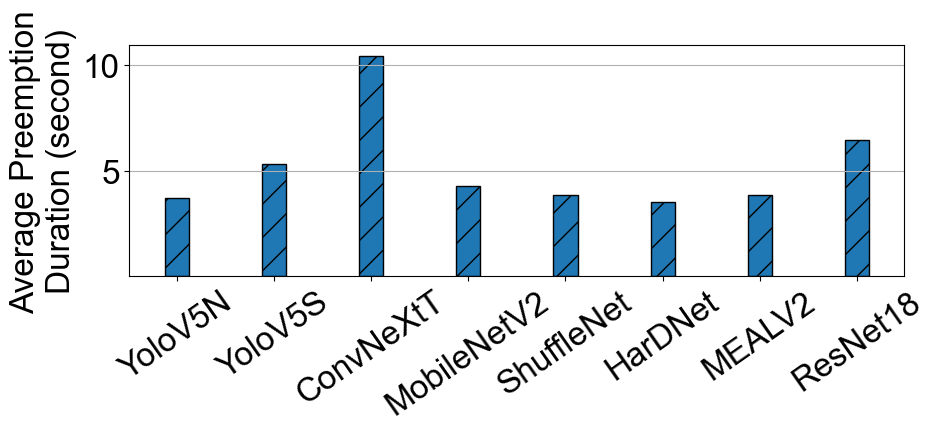

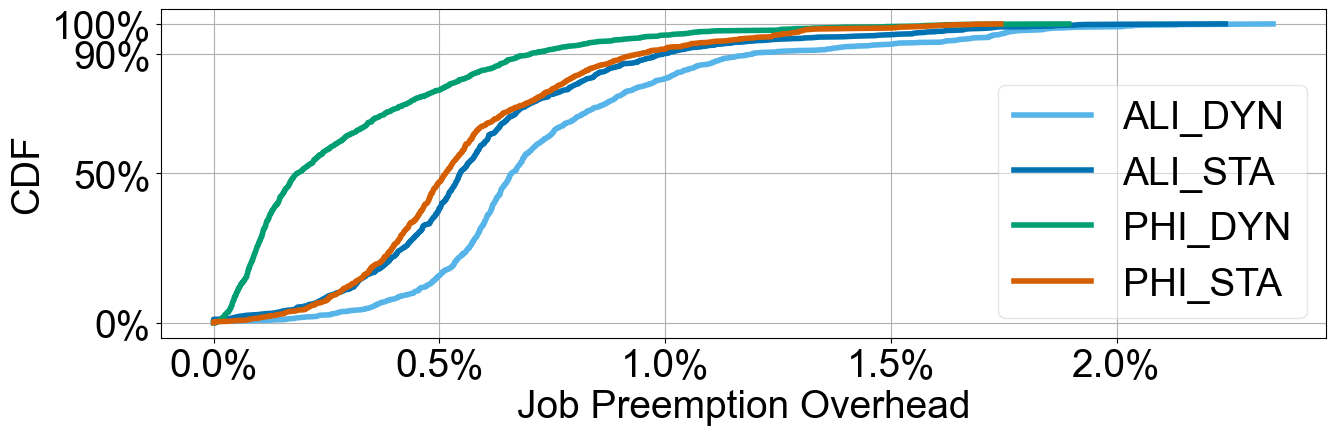

In [6]:
print(checkpoint_infos)
plot_checkpoint_overhead_bar()
plot_checkpoint_record_cdfs()
